In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import string
import re
import unicodedata
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
# Load data
data = pd.read_csv("chat_health.csv")
data = data.head(500)

# Define function to convert unicode to ASCII
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

# Define text cleaning function
def clean_text(text):
    text = unicode_to_ascii(text.lower().strip())
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\r", "", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub("(\\W)"," ",text)
    text = re.sub('\S*\d\S*\s*','', text)
    return text

data["short_question"] = data.short_question.apply(clean_text)
data["short_answer"] = data.short_answer.apply(clean_text)

# Text preprocessing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['short_question'].tolist() + data['short_answer'].tolist())
vocab_size = len(tokenizer.word_index) + 1

questions_seq = tokenizer.texts_to_sequences(data['short_question'])
answers_seq = tokenizer.texts_to_sequences(data['short_answer'])

max_length = max(max(len(x) for x in questions_seq), max(len(x) for x in answers_seq))
questions_padded = pad_sequences(questions_seq, maxlen=max_length, padding='post')
answers_padded = pad_sequences(answers_seq, maxlen=max_length, padding='post')

# Split dataset
train_questions, val_questions, train_answers, val_answers = train_test_split(
    questions_padded, answers_padded, test_size=0.1, random_state=42)

# Prepare training and validation datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_questions, train_answers))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(16).repeat()

val_dataset = tf.data.Dataset.from_tensor_slices((val_questions, val_answers))
val_dataset = val_dataset.batch(16).repeat()

# Build model
model = Sequential([
    Embedding(vocab_size, 128, input_length=max_length),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.5),
    BatchNormalization(),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.5),
    Dense(vocab_size, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Adjust batch_size or directly use the entire dataset
batch_size = 16
class CombinedStoppingCallback(Callback):
    def __init__(self, loss_threshold=0.01, improvement_threshold=0.01, patience=200):
        super(CombinedStoppingCallback, self).__init__()
        self.loss_threshold = loss_threshold  # Stop training if loss is below this value
        self.improvement_threshold = improvement_threshold  # Consider stopping if improvement is less than this value
        self.patience = patience  # Max consecutive epochs to wait before deciding to stop
        self.best_loss = float('inf')
        self.best_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('loss')
        if current_loss is None:
            return

        # Check if the loss has reached below the threshold
        if current_loss < self.loss_threshold:
            print(f"\nEpoch {epoch}: Stopping training as loss {current_loss} is below threshold {self.loss_threshold}.")
            self.model.stop_training = True

        # Check if there is a significant improvement in loss
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.best_epoch = epoch
        else:
            # Check if it has been 'patience' epochs since the last best loss and the improvement is not enough
            if (epoch - self.best_epoch) >= self.patience and (self.best_loss - current_loss) < self.improvement_threshold:
                print(f"\nEpoch {epoch}: No significant improvement in loss for {self.patience} epochs. Stopping training.")
                self.model.stop_training = True

# Create an instance of CombinedStoppingCallback
stopping_callback = CombinedStoppingCallback(loss_threshold=0.1, improvement_threshold=0.1, patience=50)

# Use the model and save training history
history = model.fit(
    train_dataset,
    epochs=2000,
    steps_per_epoch=max(1, len(train_questions) // batch_size),
    validation_data=val_dataset,
    validation_steps=max(1, len(val_questions) // batch_size),
    callbacks=[stopping_callback]
)

Epoch 1/2000
28/28 [==============================] - 57s 2s/step - loss: 4.8639 - accuracy: 0.4663 - val_loss: 4.4959 - val_accuracy: 0.5038
Epoch 2/2000
28/28 [==============================] - 41s 1s/step - loss: 3.6300 - accuracy: 0.5147 - val_loss: 4.0570 - val_accuracy: 0.5038
Epoch 3/2000
28/28 [==============================] - 41s 1s/step - loss: 3.6042 - accuracy: 0.5097 - val_loss: 4.0917 - val_accuracy: 0.5038
Epoch 4/2000
28/28 [==============================] - 40s 1s/step - loss: 3.5019 - accuracy: 0.5169 - val_loss: 3.9491 - val_accuracy: 0.5038
Epoch 5/2000
28/28 [==============================] - 41s 1s/step - loss: 3.4794 - accuracy: 0.5114 - val_loss: 3.9793 - val_accuracy: 0.5038
Epoch 6/2000
28/28 [==============================] - 41s 1s/step - loss: 3.4352 - accuracy: 0.5136 - val_loss: 3.9810 - val_accuracy: 0.5041
Epoch 7/2000
28/28 [==============================] - 40s 1s/step - loss: 3.3657 - accuracy: 0.5184 - val_loss: 4.0282 - val_accuracy: 0.5041
Epoch 

In [3]:
# Save the model to an HDF5 file
model.save('model_LSTM_50.h5')

# save Tokenizer
import pickle
with open('tokenizer_LSTM_50.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [4]:
from tensorflow.keras.models import load_model
import pickle

# load model
model = load_model('model_LSTM_50.h5')

# load Tokenizer
with open('tokenizer_LSTM_50.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


In [5]:
# generate answer
def generate_answer(question,model):
    question_seq = tokenizer.texts_to_sequences([question])
    question_padded = pad_sequences(question_seq, maxlen=max_length, padding='post')
    prediction = model.predict(question_padded)
    predicted_indices = np.argmax(prediction, axis=-1)[0]
    predicted_words = ' '.join([tokenizer.index_word[i] for i in predicted_indices if i != 0])
    return predicted_words

In [10]:
testData = pd.read_csv('chat_health.csv').head(500)

In [11]:
from nltk.translate.bleu_score import corpus_bleu
testData['generated_answer'] = testData['short_question'].apply(lambda q: generate_answer(q, model))

references = testData['short_answer'].apply(lambda a: [a.split()]).tolist()
candidates = testData['generated_answer'].apply(lambda a: a.split()).tolist()

bleu_score = corpus_bleu(references, candidates)
print("BLEU Score:", bleu_score)

1/1 [==============================] - 0s 86ms/step
BLEU Score: 0.744201137061295


In [12]:
import time
start_time = time.time()
testData['generated_answer'] = testData['short_question'].head(50).apply(lambda q: generate_answer(q, model))
end_time = time.time()
response_time = end_time - start_time
average_response_time = response_time / 50

print(f"Average response time per record: {average_response_time} seconds")

1/1 [==============================] - 0s 81ms/step
Average response time per record: 0.19891045570373536 seconds


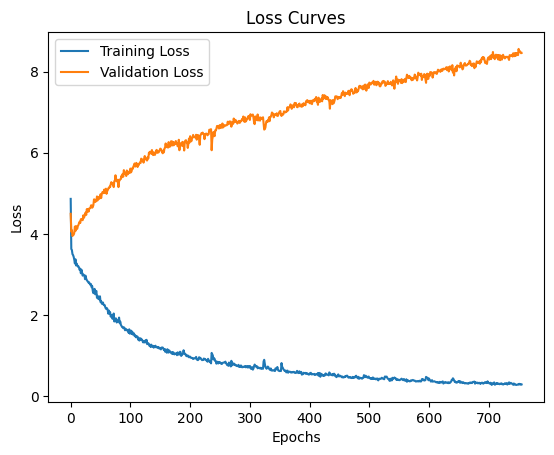

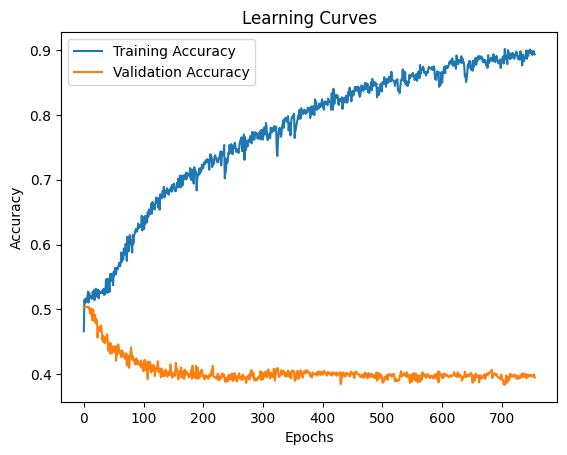

In [13]:
import matplotlib.pyplot as plt
# Plotting loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

# Plotting accuracy curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curves')
plt.show()